In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.plotly as py
import plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.ticker import FuncFormatter
from pandas_datareader import data as pdr
from time import gmtime, strftime
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [3]:
import cufflinks as cf

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('A última vez que este script foi executado foi em:', a)

A última vez que este script foi executado foi em: 2017-10-09 13:16:25


In [5]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [6]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2007-10-31"
                           
MSid = ['F0GBR06T6O']
Nomes = ['PimcoRR']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

In [7]:
fundos.head()

,PimcoRR
date,
2007-10-31,11.55
2007-11-01,11.59
2007-11-02,11.68
2007-11-05,11.68
2007-11-06,11.69


In [8]:
fundos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2451 entries, 2007-10-31 to 2017-10-06
Data columns (total 1 columns):
PimcoRR    2451 non-null float64
dtypes: float64(1)
memory usage: 38.3 KB


In [9]:
# download quotes
tickers = ['TIP']
Quotes = pd.DataFrame()
Start ='2007-10-31'

for t in tickers:
    Quotes[t] =pdr.get_data_yahoo(t, start=Start)['Adj Close']

In [10]:
Quotes.head()

,TIP
Date,
2007-10-31,78.872795
2007-11-01,79.596245
2007-11-02,80.042656
2007-11-05,80.081123
2007-11-06,80.088821


In [11]:
Quotes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502 entries, 2007-10-31 to 2017-10-06
Data columns (total 1 columns):
TIP    2502 non-null float64
dtypes: float64(1)
memory usage: 39.1 KB


In [12]:
Quotes_df = Quotes.merge(fundos, left_index = True, right_index = True, how='outer')

In [13]:
Quotes_df.head()

,TIP,PimcoRR
2007-10-31,78.872795,11.55
2007-11-01,79.596245,11.59
2007-11-02,80.042656,11.68
2007-11-05,80.081123,11.68
2007-11-06,80.088821,11.69


In [14]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502 entries, 2007-10-31 to 2017-10-06
Data columns (total 2 columns):
TIP        2502 non-null float64
PimcoRR    2451 non-null float64
dtypes: float64(2)
memory usage: 58.6 KB


In [15]:
# Reordering the columns
Quotes_df = Quotes_df[['PimcoRR', 'TIP']]

In [16]:
Quotes_df = Quotes_df.fillna(method='ffill')

In [17]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502 entries, 2007-10-31 to 2017-10-06
Data columns (total 2 columns):
PimcoRR    2502 non-null float64
TIP        2502 non-null float64
dtypes: float64(2)
memory usage: 58.6 KB


In [18]:
#### Returns ####
returns = (Quotes_df / Quotes_df.shift(1)) - 1

In [19]:
#### Normalization to 100 ####
Quotes_df_norm = (Quotes_df / Quotes_df.iloc[0] * 100)

In [20]:
#### Desvio padrão dos fundos ####
Fundos_std = returns.apply(func = np.std)
Fundos_std = pd.DataFrame(Fundos_std).transpose()  * 1000
Fundos_std

,PimcoRR,TIP
0,3.466306,4.186016


In [21]:
Quotes_df_norm.iplot(kind='spread',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos')

In [22]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(Quotes_df_norm), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem')

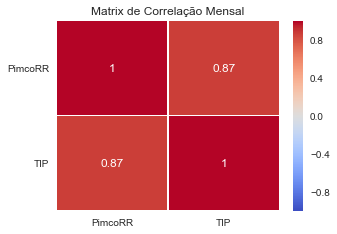

In [23]:
#### Get monthly returns for correlation matrix
Quotes_monthly = Quotes_df_norm.resample('BM').last().copy()
Returns_monthly = (Quotes_monthly / Quotes_monthly.shift(1)) - 1

##### New Preturns (to include Portfolio returns) ####
Preturns = Returns_monthly.copy()

##### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = Preturns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3.5) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin=-1)
plt.yticks(rotation=360)
plt.title('Matrix de Correlação Mensal')
plt.show()

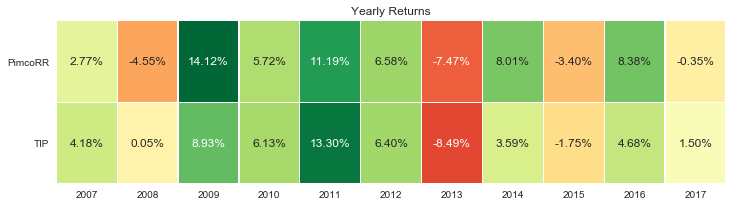

In [24]:
# Resampling to yearly (business year)
yearly_quotes = Quotes_df_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([Quotes_df_norm.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2006, 2018))]).drop(2006)

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12, 3) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()